In [1]:
from z3 import *

x = Real('x')
y = Real('y')
s = Solver()
s.add(x + y > 5, x > 1, y > 1)
print(s.check())
print(s.model())

sat
[y = 4, x = 2]


In [81]:
# del x,y,z
# exec("x = Int('x')")
# exec("y = Int('y')")
exec("x,y,z = Ints('x y z')")

In [82]:
# x = Int('x')
# y = Int('y')
s = "And(x == y, Not(x == y))"
f2 = eval(s)
print(f2)
s = Solver()
s.add(f2)
print(s.check())
# print(s.model())

And(x == y, Not(x == y))
unsat


In [21]:
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_columns', 500)

housing_data = pd.read_csv('./Data/kc_house_data.csv')

In [3]:
sqft_cols = [i for i in housing_data.columns if 'sqft' in i]

In [4]:
X = housing_data[sqft_cols]
y = housing_data['price']
X.head()

,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15
0,1180,5650,1180,0,1340,5650
1,2570,7242,2170,400,1690,7639
2,770,10000,770,0,2720,8062
3,1960,5000,1050,910,1360,5000
4,1680,8080,1680,0,1800,7503


In [5]:
from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.experimental import enable_hist_gradient_boosting
# from sklearn.ensemble import HistGradientBoostingRegressor

gbr = GradientBoostingRegressor(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=50  # number of trees
)

gbr.fit(X,y)


GradientBoostingRegressor(n_estimators=50)

In [6]:
import sklearn
help(sklearn.tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : int
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : int
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : int
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of int, shape [node_count]
 |      children_left[i] holds the node id of the left child 

In [7]:
tree = gbr.estimators_[0,0].tree_


In [8]:
tree = gbr.estimators_[0,0].tree_

In [9]:
from copy import deepcopy

In [10]:
X_sample = X.iloc[0]
X_sample

sqft_living      1180
sqft_lot         5650
sqft_above       1180
sqft_basement       0
sqft_living15    1340
sqft_lot15       5650
Name: 0, dtype: int64

In [11]:
tree.feature

array([ 0,  0,  0, -2, -2,  4, -2, -2,  0,  0, -2, -2,  0, -2, -2],
      dtype=int64)

In [12]:
tree.threshold

array([ 3.4060e+03,  2.2595e+03,  1.5290e+03, -2.0000e+00, -2.0000e+00,
        2.8550e+03, -2.0000e+00, -2.0000e+00,  4.7550e+03,  4.0625e+03,
       -2.0000e+00, -2.0000e+00,  7.9400e+03, -2.0000e+00, -2.0000e+00])

In [13]:
tree.value

array([[[-1.47999839e-09]],

       [[-6.10828458e+04]],

       [[-1.34412441e+05]],

       [[-1.91935984e+05]],

       [[-8.40043399e+04]],

       [[ 1.16067214e+05]],

       [[ 7.46733480e+04]],

       [[ 2.81749637e+05]],

       [[ 6.83101792e+05]],

       [[ 5.52206432e+05]],

       [[ 4.52079996e+05]],

       [[ 7.87092838e+05]],

       [[ 1.42846442e+06]],

       [[ 1.30639080e+06]],

       [[ 4.54134186e+06]]])

In [221]:
# do this just for regression to start

##### HOW TO GENERATE LOGICAL REPRESENTATIONS

### Leaf encoding
# run a DFS on the tree, store nodes in a stack

# when you reach a leaf, write the logical statements for 
# pi(l) which is stack[1:] n wl where wl is the weight value of the leaf

# DFS
def dfs(tree, tree_num=0, X_input=None, epsilon=160, scale=0.1, verbose=False):
    paths = []
    pi_l = []  # this will be a list of lists of every pi_l ie: ['xi_1 <= 1000', 'xi_2 > 6000'..., wl]
    stack=[0]  # initialize stack for tree
    pi_l_stack=[]  # a stack for holding pi_l definitions based on position in tree
    n_nodes = tree.node_count
    threshold = tree.threshold 
    feature = tree.feature
    left_searched = [False for _ in range(n_nodes)]
    right_searched = [False for _ in range(n_nodes)]
    children_left = tree.children_left
    children_right = tree.children_right
    values = tree.value  # I think these are the average value (or something) of a node based on training data
    
    reals = set(['out',])  # this is a set of reals that we will be adding to to instantiate later, any time we encounter a variable we will add to it
    variables = set()  # this is used for variable constraints
    
    while True:
        this_node = stack[-1]
        this_threshold = threshold[this_node]
        this_feature = feature[this_node]

        searched_left_already = left_searched[this_node]
        searched_right_already = right_searched[this_node]
        
        # define tree pruning
        
        if children_left[this_node] == -1:  # if leaf node we dont do pruning even if a threshold is defined
            pass  # no pruning
        elif X_input is not None:
            lower_bound = X_input.iloc[this_feature]-epsilon
            upper_bound = X_input.iloc[this_feature]+epsilon
            if lower_bound <= this_threshold <= upper_bound:
                pass  # no pruning because threshold within boundary, permissiable values on either side of threshold
            elif this_threshold < lower_bound:
                left_searched[this_node]=True  # prune left side because no possible value for this allowable input range will go down left side
            elif upper_bound < this_threshold:
                right_searched[this_node]=True # prune right side because no possible value for this allowable input range will go down right side
        
        # check if we need to search any more nodes at this level or go up previous one
        if searched_left_already and searched_right_already and this_node==0:
            break  # special condition from pruning where we have returned to the root of the tree after searching everything else
        elif searched_left_already and searched_right_already:
            stack.pop(-1)  # pop the last node off of the stack so we go one level up on the next run
            pi_l_stack.pop(-1)
            continue
        
        if not searched_left_already:  # search the left_child
            child = children_left[this_node]
            this_op = f'x_{this_feature} <= {this_threshold}'  # I wasn't sure exactly how these should be defined
            left_searched[this_node]=True
        else:  # search the right child
            child = children_right[this_node]
            this_op = f'x_{this_feature} > {this_threshold}'
            right_searched[this_node]=True

        if child==-1:  # at leaf
            # append path to this node + the value of this node
            this_path = deepcopy(stack[1:])+[deepcopy(values[this_node][0,0])]
            this_pi_l = deepcopy(pi_l_stack[:])+[f'wl_{tree_num}=='+deepcopy(str(scale*values[this_node][0,0]))]
            reals.add(f'wl_{tree_num}')  # adding this leaf node to the list of reals we need to instantiate
            paths.append(this_path)
            pi_l.append(this_pi_l)
            result='And('+', '.join(this_pi_l)+')'
            if verbose:
                print(this_path, result)

            if this_node == n_nodes-1:
                break  # we have searched all paths and can break
            stack.pop(-1)  # pop the last node off of the stack so we go one level up on the next run
            pi_l_stack.pop(-1)
        else:  # not at leaf
            # append the child to the stack and continue search
            stack.append(child)     
            pi_l_stack.append(this_op)
            reals.add(f'x_{this_feature}')  # add this feature to the set of reals, its okay if we choose to discard this path later
            variables.add(f'x_{this_feature}')
            
    return pi_l, reals, variables

# pruning: using an input x_i', compare the difference at every node in the DFS x_i
# if |x_i-x_i'| < epsilon where epsilon is the predefined robustness factor
# then keep node, otherwise pop current node from the stack and 
# stop searching this branch of the tree (return to previous level)

### Tree encoding
# then represent PI(D) as V(pi(l)) a disjunction of all pi(l) found during DFS

### GBM encoding
# lastly encode the full model instelf, (n(PI(D_i))) n (out=sum(wl_i))
# I haven't fulling figured out how to represent the out=sum(wl_i) part yet.
# wl_i should be the one value returned from each tree PI(D_i), we might just 
# need the additional predicate D_i(x)=wl_i meaning that putting x into the decision tree returns wl_i
# but I'm not totally sure how this is expressed for Z3

# gamma_R is the model encoding and referenced in the paper
def get_gamma_R(gbr_model, X_input, epsilon=160, delta=100000):
    all_pi_l = []
    all_reals = set()
    all_variables = set()
    scale = gbr_model.learning_rate
    for t in range(len(gbr_model.estimators_)):
        tree = gbr_model.estimators_[t,0].tree_
        this_pi_l, reals, variables = dfs(tree, tree_num=t, X_input=X_input, epsilon=epsilon, scale=scale)
        all_pi_l.append(this_pi_l)
        all_reals = all_reals.union(reals)
        all_variables = all_variables.union(variables)
        
    all_PI_Ds = []
    for r in range(len(all_pi_l)):
        this_PI_D = all_pi_l[r]
        PI_D = '\tOr(\n\t\t'+',\n\t\t'.join(['And('+', '.join(this_pi_l)+')' for this_pi_l in this_PI_D])+'\n\t)'
        all_PI_Ds.append(PI_D)

        # print('\nTree Representation PI(D):\n',PI_D,sep='')

    # construct variable constraints
    variable_constraints = []
    for x_i in list(all_variables):
        this_index = int(x_i[2:])  # everything looks like x_i so indexing from x_[i..]
        i_value = X_input.iloc[this_index]
        var_robustness1 = f'{x_i} <= {i_value+epsilon}'
        var_robustness2 = f'{i_value-epsilon} <= {x_i}'  # ensures that x_i is withing these boundaries
        variable_constraints.append(f'And({var_robustness1}, {var_robustness2})')
        
    out = 'out=='+'+'.join([f'wl_{t}' for t in range(len(all_pi_l))])
    
    # calculate the residual value for the input
    X_sample = np.array(X_input).reshape(1,-1)
    input_regression_value = 0 # This is R(x), the residual value of the original input
    n_estimators = gbr_model.n_estimators
    scale = gbr_model.learning_rate
    for t in range(n_estimators):
        estimator = gbr_model.estimators_[t,0]  # this is a regressor so there is only one output hence the 0
        value_in_decision_tree = estimator.predict(X_sample)[0]
        input_regression_value += scale*value_in_decision_tree  
    
    output_robustness1 = f'{input_regression_value+delta} < out'
    output_robustness2 = f'out < {input_regression_value-delta}'  # these two lines will ensure that all out values are OUTSIDE delta of the input regression value, so that if there is a counter-example then it will be found
    output_robustness = f'Or({output_robustness2}, {output_robustness1})'
    
    gamma_R = ',\n'.join(all_PI_Ds)
    gamma_R = 'And(\n\t'+',\n\t'.join(variable_constraints)+',\n\t'+output_robustness+',\n\t'+out+',\n'+gamma_R+'\n)'

    # print(out)
    # print(gamma_R)
    return gamma_R, all_reals

# out='wl_1+wl_2+...'

### Robust property encoding
# see section 5 of the paper this is easier than the previous stuff but it 
# again has stuff like R(x) that I need to read the documentation on how to define




In [222]:
# gbr.predict(np.array(X_sample).reshape(1,-1))[0]

In [223]:
model_expression, all_reals = get_gamma_R(gbr, X_input=X_sample)

In [224]:
print(model_expression)

And(
	And(x_0 <= 2480, 2160 <= x_0),
	And(x_2 <= 2480, 2160 <= x_2),
	And(x_1 <= 37007, 36687 <= x_1),
	And(x_4 <= 2710, 2390 <= x_4),
	And(x_5 <= 35225, 34905 <= x_5),
	And(x_3 <= 160, -160 <= x_3),
	Or(out < -84772.91217862547, 115227.08782137453 < out),
	out==wl_0+wl_1+wl_2+wl_3+wl_4+wl_5+wl_6+wl_7+wl_8+wl_9+wl_10+wl_11+wl_12+wl_13+wl_14+wl_15+wl_16+wl_17+wl_18+wl_19+wl_20+wl_21+wl_22+wl_23+wl_24+wl_25+wl_26+wl_27+wl_28+wl_29+wl_30+wl_31+wl_32+wl_33+wl_34+wl_35+wl_36+wl_37+wl_38+wl_39+wl_40+wl_41+wl_42+wl_43+wl_44+wl_45+wl_46+wl_47+wl_48+wl_49,
	Or(
		And(x_0 <= 3406.0, x_0 <= 2259.5, x_0 <= 1529.0, wl_0==-19193.59836710138),
		And(x_0 <= 3406.0, x_0 <= 2259.5, x_0 > 1529.0, wl_0==-8400.433994787229),
		And(x_0 <= 3406.0, x_0 > 2259.5, x_4 <= 2855.0, wl_0==7467.334801182247)
	),
	Or(
		And(x_0 <= 2847.5, x_0 <= 2009.5, x_5 <= 6023.5, wl_1==-8509.566278383158),
		And(x_0 <= 2847.5, x_0 <= 2009.5, x_5 > 6023.5, wl_1==-17712.642461887295),
		And(x_0 <= 2847.5, x_0 > 2009.5, x_4 <= 2669

In [225]:
all_reals

{'out',
 'wl_0',
 'wl_1',
 'wl_10',
 'wl_11',
 'wl_12',
 'wl_13',
 'wl_14',
 'wl_15',
 'wl_16',
 'wl_17',
 'wl_18',
 'wl_19',
 'wl_2',
 'wl_20',
 'wl_21',
 'wl_22',
 'wl_23',
 'wl_24',
 'wl_25',
 'wl_26',
 'wl_27',
 'wl_28',
 'wl_29',
 'wl_3',
 'wl_30',
 'wl_31',
 'wl_32',
 'wl_33',
 'wl_34',
 'wl_35',
 'wl_36',
 'wl_37',
 'wl_38',
 'wl_39',
 'wl_4',
 'wl_40',
 'wl_41',
 'wl_42',
 'wl_43',
 'wl_44',
 'wl_45',
 'wl_46',
 'wl_47',
 'wl_48',
 'wl_49',
 'wl_5',
 'wl_6',
 'wl_7',
 'wl_8',
 'wl_9',
 'x_0',
 'x_1',
 'x_2',
 'x_3',
 'x_4',
 'x_5'}

In [255]:
import re

# define all real values
exec(",".join(list(all_reals))+" = Reals('"+" ".join(list(all_reals))+"')")


model_expression = re.sub("\s+", # one or more repetition of whitespace
       '', # replace with empty string (->remove)
       model_expression
      )
gamma_ = eval(model_expression)

In [256]:
s = Solver()
s.add(gamma_)
solver_result = s.check()
print(solver_result)
if s.check() == sat:
    out_value = s.model()[out]
    print(float(out_value.numerator_as_long())/float(out_value.denominator_as_long()))

sat
389530.0811259781


In [257]:
# confirm value of out that it was being returned properly
out_sum = 0
for i in range(50):
    wl_i = eval(f's.model()[wl_{i}]')
    out_sum+= float(wl_i.numerator_as_long())/float(wl_i.denominator_as_long())
out_sum

389530.0811259783

In [258]:
# convert solver counter-example result to output we can digest
v0,v1,v2,v3,v4,v5 = s.model()[x_0],\
                    s.model()[x_1],\
                    s.model()[x_2],\
                    s.model()[x_3],\
                    s.model()[x_4],\
                    s.model()[x_5]
counter_example = [
    float(v0.numerator_as_long())/float(v0.denominator_as_long()),
    float(v1.numerator_as_long())/float(v1.denominator_as_long()),
    float(v2.numerator_as_long())/float(v2.denominator_as_long()),
    float(v3.numerator_as_long())/float(v3.denominator_as_long()),
    float(v4.numerator_as_long())/float(v4.denominator_as_long()),
    float(v5.numerator_as_long())/float(v5.denominator_as_long())
]
counter_example = pd.Series(counter_example, index=X_sample.index)

In [259]:
# I wanted to visually check that the results were within epsilon distance of eachother
print(counter_example)
print(X_sample)

sqft_living       3279.0
sqft_lot         14182.0
sqft_above        3090.0
sqft_basement       96.0
sqft_living15     2917.0
sqft_lot15       10884.0
dtype: float64
sqft_living       3250
sqft_lot         14342
sqft_above        3250
sqft_basement        0
sqft_living15     2960
sqft_lot15       11044
Name: 58, dtype: int64


In [260]:
# checking the prediction results, they should be outside of 100k of eachother if/since a counter example was found
print(gbr.predict(np.array(counter_example).reshape(1,-1))[0])
print(gbr.predict(np.array(X_sample).reshape(1,-1))[0])

929618.2228925077
790771.405817428


This wasn't matching the value of out from the solver so need to figure out which trees are not solving equivalently so we can check whats going wrong with them (probably a pruning issue).

In [261]:
# I thought something was going wrong with my solver so I wanted to evaluate the result from the solver
# with the result from the individual trees, it appears that there is no difference which surprised me when I thought something was going wrong
# but my problem was actually that I didn't understand how the GBR was working and that it adds the result to a baseline value
for t in range(50):
    counter_example_value_in_gbr = 0.1*gbr.estimators_[t,0].predict(np.array(counter_example).reshape(1,-1))[0]
    exec(f'a = wl_{t}')  # creates a variable pointing to real variable name
    counter_example_value_in_solver = eval(str(s.model()[a]))
    
    if counter_example_value_in_gbr != counter_example_value_in_solver:  # if theres a discrepancy in value print the tree in question
        print(t, counter_example_value_in_gbr, counter_example_value_in_solver)

In [262]:
# raw predictions initializations
# GBR basically learn residuals from a base prediction so this calculates the base prediction
# I kind of knew about learning the residuals part but forgot about it till I dug into the source code
# see _raw_predict_init_method at https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/ensemble/_gb.py#L1282
print(gbr.loss_.get_init_raw_predictions(
                np.array(X_sample).reshape(1,-1), 
                gbr.init_).astype(np.float64))
print(gbr.loss_.get_init_raw_predictions(
                np.array(counter_example).reshape(1,-1), 
                gbr.init_).astype(np.float64))

[[540088.14176653]]
[[540088.14176653]]


In [263]:
# confirm value of tree - This will sum the individual tree predictions and should be the residual that gets added to the baseline
out_sum = 0
for t in range(50):
    estimator = gbr.estimators_[t,0]
    value_in_decision_tree = estimator.predict(np.array(X_sample).reshape(1,-1))[0]
    out_sum += .1*value_in_decision_tree
print(out_sum)

250683.26405089835


adding this value to the baseline gives us the result that we get when we 'predict' on the whole GBR

[Text(837.0, 713.475, 'X[0] <= 2847.5\nfriedman_mse = 121156048730.935\nsamples = 21613\nvalue = -0.0'),
 Text(418.5, 509.625, 'X[0] <= 2009.5\nfriedman_mse = 38941851476.932\nsamples = 17873\nvalue = -84693.436'),
 Text(209.25, 305.775, 'X[5] <= 6023.5\nfriedman_mse = 23869361531.291\nsamples = 11717\nvalue = -139676.337'),
 Text(104.625, 101.92499999999995, 'friedman_mse = 24605713367.792\nsamples = 4768\nvalue = -85095.663'),
 Text(313.875, 101.92499999999995, 'friedman_mse = 19917559628.451\nsamples = 6949\nvalue = -177126.425'),
 Text(627.75, 305.775, 'X[4] <= 2669.5\nfriedman_mse = 50924039219.876\nsamples = 6156\nvalue = 19958.068'),
 Text(523.125, 101.92499999999995, 'friedman_mse = 42047976608.591\nsamples = 5279\nvalue = -4084.43'),
 Text(732.375, 101.92499999999995, 'friedman_mse = 79928837506.651\nsamples = 877\nvalue = 164679.104'),
 Text(1255.5, 509.625, 'X[0] <= 4195.0\nfriedman_mse = 315954732866.938\nsamples = 3740\nvalue = 404739.512'),
 Text(1046.25, 305.775, 'X[0] <

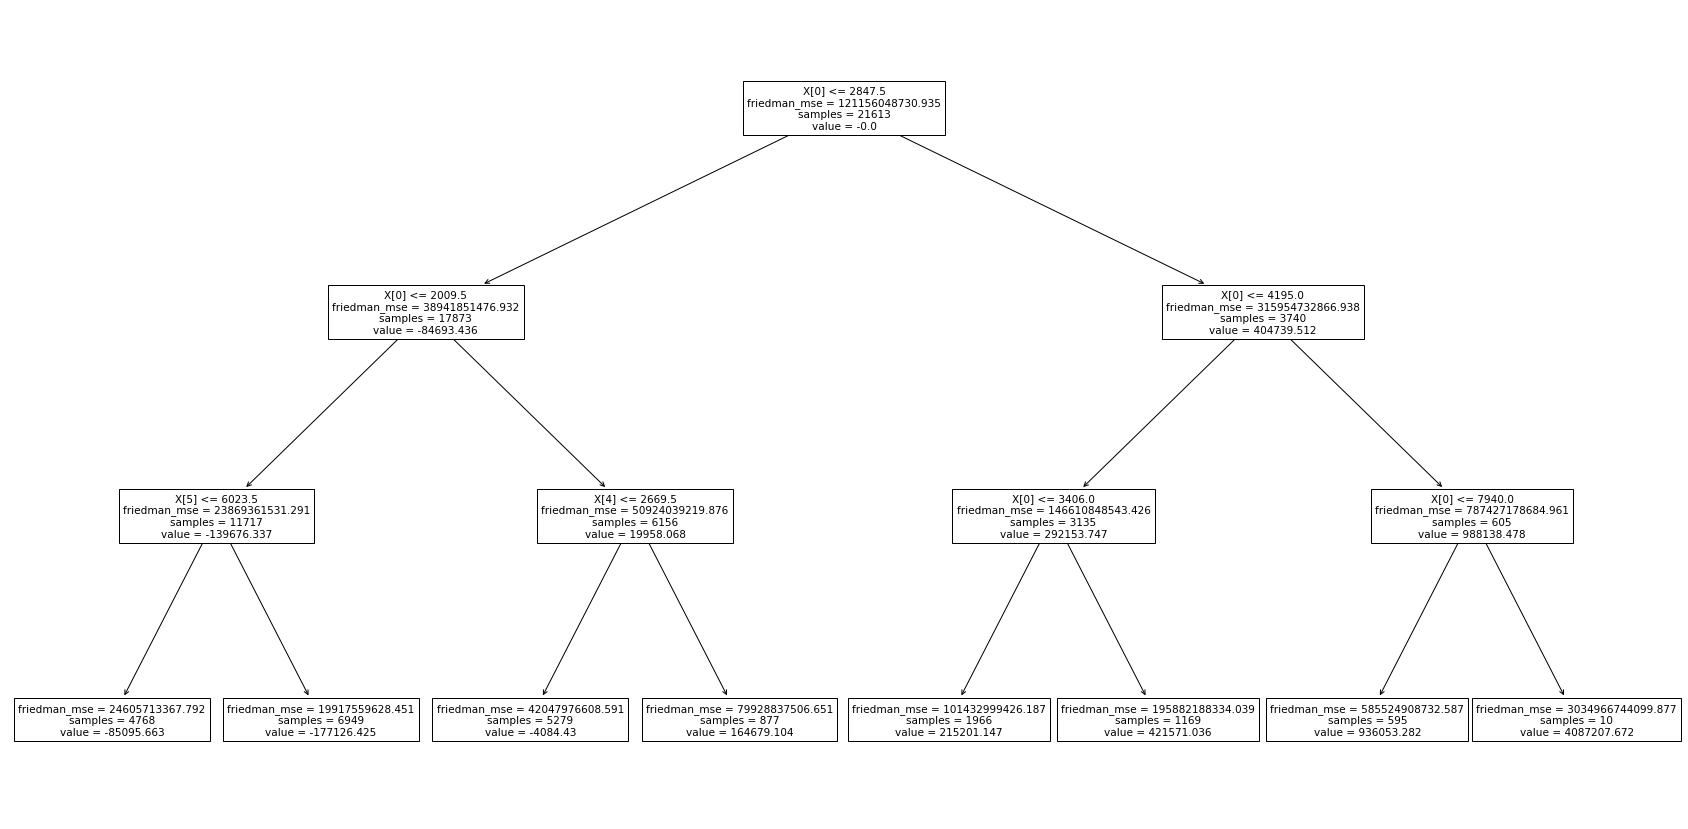

In [250]:
# I thought something was going wrong with the tree and wanted to see a visualization of it so I could manually check if something was going wrong
from sklearn import tree
import matplotlib.pyplot as plt

t=1
plt.figure(figsize=(30,15))
tree.plot_tree(gbr.estimators_[t,0])

### Experiment

In [284]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

np.random.seed(0)

X = housing_data[sqft_cols]
y = housing_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

n = 1000*60*10  # 10 minutes
set_option(timeout=n)  # n = milliseconds from https://github.com/Z3Prover/z3/issues/1386

tree_depth_options = [3,5,8,10]
estimator_options = [50, 100, 200, 300, 400, 500]

for max_depth in tree_depth_options:
    for estimators in estimator_options:
        print(f'Testing for estimators={estimators}, max_depth={max_depth}')

        gbr = GradientBoostingRegressor(
            max_depth=max_depth,
            learning_rate=0.1,
            n_estimators=estimators  # number of trees
        )

        gbr.fit(X_train, y_train)
        
        y_pred = gbr.predict(X_test)
        this_score = r2_score(y_test, y_pred)
        print(f"Test r2 score: {this_score:.02f}")

        sat_count = 0
        timeout_count = 0
        number_sampled = 200

        sampled_indexes = np.random.randint(low=0, high=len(X_test), size=number_sampled)

        verbose = False
        for i, idx in enumerate(sampled_indexes):
            if verbose:
                print(f'testing sample {i}, index: {idx}')
            X_sample = X_test.iloc[idx]

            # I wanted to confirm that every value starts with the same initial prediction and that is true
        #     print(gbr.loss_.get_init_raw_predictions(
        #                 np.array(X_sample).reshape(1,-1), 
        #                 gbr.init_).astype(np.float64))  

            model_expression, all_reals = get_gamma_R(gbr, X_input=X_sample)

            # define all real values
            exec(",".join(list(all_reals))+" = Reals('"+" ".join(list(all_reals))+"')")


            model_expression = re.sub("\s+", # one or more repetition of whitespace
                   '', # replace with empty string (->remove)
                   model_expression
                  )
            gamma_ = eval(model_expression)

            s = Solver()
            s.add(gamma_)
            solver_result = s.check()
            if verbose:
                print(solver_result)
            if s.check() == sat:
                sat_count+=1
                out_value = s.model()[out]
                if verbose: 
                    print(float(out_value.numerator_as_long())/float(out_value.denominator_as_long()))
            if s.check() == unknown:
                timeout_count+=1
                if verbose:
                    print('timeout found')

            if ((i+1)%50) == 0:
                print(f'Tested {i+1} cases so far')

        results_dict = {
            'sat_rate':sat_count/number_sampled,
            'unsat_rate': (number_sampled-sat_count-timeout_count)/number_sampled,
            'timeout_rate': timeout_count/number_sampled,
            'r2_score': this_score
        }

        print(results_dict)
        
        with open(f'ReplicationResults/results_estimators={estimators}_depth={max_depth}.pkl', 'wb+') as file:
            pickle.dump(results_dict, file)

Testing for estimators=50, max_depth=3
Test r2 score: 0.61
Tested 50 cases so far
Tested 100 cases so far
Tested 150 cases so far
Tested 200 cases so far
{'sat_rate': 0.335, 'unsat_rate': 0.665, 'timeout_rate': 0.0, 'r2_score': 0.6056243087302053}
Testing for estimators=100, max_depth=3
Test r2 score: 0.61
Tested 50 cases so far
Tested 100 cases so far
Tested 150 cases so far
Tested 200 cases so far
{'sat_rate': 0.37, 'unsat_rate': 0.63, 'timeout_rate': 0.0, 'r2_score': 0.6098890580686213}
Testing for estimators=200, max_depth=3
Test r2 score: 0.61
Tested 50 cases so far
Tested 100 cases so far
Tested 150 cases so far
Tested 200 cases so far
{'sat_rate': 0.615, 'unsat_rate': 0.385, 'timeout_rate': 0.0, 'r2_score': 0.6101307139804514}
Testing for estimators=300, max_depth=3
Test r2 score: 0.61
Tested 50 cases so far
Tested 100 cases so far
Tested 150 cases so far
Tested 200 cases so far
{'sat_rate': 0.635, 'unsat_rate': 0.365, 'timeout_rate': 0.0, 'r2_score': 0.605677316033516}
Testing 

In [285]:
with open(f'ReplicationResults/results_estimators={estimators}_depth={max_depth}.pkl', 'rb+') as file:
    results_out = pickle.load(file)

In [286]:
results_out

{'sat_rate': 1.0,
 'unsat_rate': 0.0,
 'timeout_rate': 0.0,
 'r2_score': 0.5598671109062926}

TO DO:

- ~pickle results to another folder~
- ~loop over different tree sizes and depths, thats gonna run for a while, not sure what a timeout looks like so we need to test a bit on that and track those, the only happen at tree sizes 500+~
- ~make sure that we train properly (this isn't described afaik in the paper) make sure that we only test on 200 randomly sampled data cases~

In [107]:
# print(X_sample)
# print(tree.feature)
# print(tree.threshold)

In [14]:
tree.value[4][0,0]

-84004.33994787265

In [15]:
tree.children_left


array([ 1,  2,  3, -1, -1,  6, -1, -1,  9, 10, -1, -1, 13, -1, -1],
      dtype=int64)

In [16]:
tree.children_right


array([ 8,  5,  4, -1, -1,  7, -1, -1, 12, 11, -1, -1, 14, -1, -1],
      dtype=int64)

In [17]:
tree

In [53]:
import re
exec('res='+re.sub('\s', '','4+\n\t\t5'))
res

9